<a href="https://colab.research.google.com/github/remifol/SystematicReview/blob/master/Stemmed_BOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this model directly in the browser with zero setup, open it in [Colab here](https://colab.research.google.com/github/sararob/keras-wine-model/blob/master/keras-wide-deep.ipynb).

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import itertools
import os
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow as tf
import nltk
import time
import gensim
import random

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import Sequence
layers = keras.layers

from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/My Drive/Projet de maitrise/Revue systématique/Automatisation/Algorithme/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def triplet_loss(margin):
  def loss(y_true,y_pred):
    label = keras.backend.mean(y_true, axis=-1)
    return tf.contrib.losses.metric_learning.triplet_semihard_loss(embeddings = y_pred, labels = label, margin = margin)
  return loss

In [0]:
TestSize = 0.3
LearningRate = 0.001

In [0]:
#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique().tolist()

#Randomly select one subject to be the cross validation subject
ValidationSubject = Subjects.pop(np.random.randint(0,len(Subjects)))
ValidationArticles = pd.read_csv(Path+ValidationSubject+'.csv')

#Create a pool of the rest of the systematic reviews
Pooled_Systematic_Reviews = pd.read_csv(Path+Subjects[0]+'.csv')

for i in range(1,len(Subjects)):
  Review_Temp = pd.read_csv(Path+Subjects[i]+'.csv')
  print(Subjects[i]+' '+ str(len(Review_Temp)))
  #Change 0/1 label to article unique values
  Review_Temp['Label'][Review_Temp['Label']==0] = 2*i
  Review_Temp['Label'][Review_Temp['Label']==1] = 2*i+1
  Pooled_Systematic_Reviews = Pooled_Systematic_Reviews.append(Review_Temp)

ADHD 754
Antihistamines 185
AtypicalAntipsychotics 922
CalciumChannelBlockers 1095
Estrogens 190
NSAIDS 179
Opiods 1666
OralHypoglycemics 380
ProtonPumpInhibitors 1089
SkeletalMuscleRelaxants 1321
Statins 2693
Triptans 530
UrinaryIncontinence 174


In [0]:
iteration = 5
TestSizes = [0.7,0.5,0.3,0.1]


#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique().tolist()


In [0]:
#SVM
ResultDict_SVM = {}
for TestFrac in TestSizes:
  print(str(TestFrac))
  for Subject in Subjects:
    print(Subject)
    ValidationArticles = pd.read_csv(Path+Subject+'.csv')

    Acc = np.zeros(iteration)
    Sn  = np.zeros(iteration)
    Sp = np.zeros(iteration)
    F1 = np.zeros(iteration)
    for i in range(iteration):
      #SVM prediction with parsed and stemmed BOW
      X_train, X_test, y_train, y_test = train_test_split(
      ValidationArticles['StemmedArticle'], ValidationArticles['Label'], test_size=TestFrac)

      svm_BOW = Pipeline([('vect', CountVectorizer(min_df=2)),
                          ('clf-svm', linear_model.SGDClassifier(loss = 'hinge',
                                                                penalty = 'l2', 
                                                                max_iter = 10000, 
                                                                tol=1e-4, class_weight = 'balanced'
                                                                )
                          )
                         ])

      _ = svm_BOW.fit(X_train, y_train)

      y_predict = svm_BOW.predict(X_test)

      Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
      Sn[i] = recall_score(y_test,y_predict, pos_label=1)
      Sp[i] = recall_score(y_test,y_predict, pos_label=0)
      F1[i] = f1_score(y_test,y_predict, pos_label=1)
    print('Accuracy : {0:0.4f}, Sensitivity : {1:0.4f}, Specificity : {2:0.4f}, F1 score : {3:0.4f}'.format(np.mean(Acc),np.mean(Sn),np.mean(Sp),np.mean(F1)))
      
    ResultDict_SVM.update({(Subject,str(TestFrac),'SVM','Sensitivity'): Sn,
                      (Subject,str(TestFrac),'SVM','Specificity'): Sp,
                      (Subject,str(TestFrac),'SVM','Accuracy'): Acc,
                      (Subject,str(TestFrac),'SVM','F1_score'): F1})
    
#Logistic Regression
ResultDict_RegLog = {}
for TestFrac in TestSizes:
  print(TestFrac)
  for Subject in Subjects:
    print(Subject)
    ValidationArticles = pd.read_csv(Path+Subject+'.csv')

    Acc = np.zeros(iteration)
    Sn  = np.zeros(iteration)
    Sp = np.zeros(iteration)
    F1 = np.zeros(iteration)
    for i in range(iteration):
      #RegLog prediction with parsed and stemmed BOW
      X_train, X_test, y_train, y_test = train_test_split(
      ValidationArticles['StemmedArticle'], ValidationArticles['Label'], test_size=TestFrac)

      svm_BOW = Pipeline([('vect', CountVectorizer(min_df=2)),
                          ('clf-svm', linear_model.SGDClassifier(loss = 'log',
                                                                penalty = 'l2', 
                                                                max_iter = 10000, 
                                                                tol=1e-4, class_weight = 'balanced'
                                                                )
                          )
                         ])

      _ = svm_BOW.fit(X_train, y_train)

      y_predict = svm_BOW.predict(X_test)

      Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
      Sn[i] = recall_score(y_test,y_predict, pos_label=1)
      Sp[i] = recall_score(y_test,y_predict, pos_label=0)
      F1[i] = f1_score(y_test,y_predict, pos_label=1)
      
    print('Accuracy : {0:0.4f}, Sensitivity : {1:0.4f}, Specificity : {2:0.4f}, F1 score : {3:0.4f}'.format(np.mean(Acc),np.mean(Sn),np.mean(Sp),np.mean(F1)))

    ResultDict_RegLog.update({(Subject,str(TestFrac),'RegLog','Sensitivity'): Sn,
                              (Subject,str(TestFrac),'RegLog','Specificity'): Sp,
                              (Subject,str(TestFrac),'RegLog','Accuracy'): Acc,
                              (Subject,str(TestFrac),'RegLog','F1_score'): F1})

0.7
ACEInhibitors
Accuracy : 0.8958, Sensitivity : 0.3277, Specificity : 0.9439, F1 score : 0.3239
ADHD
Accuracy : 0.8648, Sensitivity : 0.6086, Specificity : 0.8959, F1 score : 0.4937
Antihistamines
Accuracy : 0.6477, Sensitivity : 0.5651, Specificity : 0.6926, F1 score : 0.5065
AtypicalAntipsychotics
Accuracy : 0.6749, Sensitivity : 0.5581, Specificity : 0.7320, F1 score : 0.5270
BetaBlockers
Accuracy : 0.8171, Sensitivity : 0.3479, Specificity : 0.8950, F1 score : 0.3460
CalciumChannelBlockers
Accuracy : 0.7478, Sensitivity : 0.5180, Specificity : 0.8195, F1 score : 0.4917
Estrogens
Accuracy : 0.6887, Sensitivity : 0.4870, Specificity : 0.7387, F1 score : 0.3873
NSAIDS
Accuracy : 0.7317, Sensitivity : 0.7026, Specificity : 0.7471, F1 score : 0.6045
Opiods
Accuracy : 0.9522, Sensitivity : 0.1364, Specificity : 0.9757, F1 score : 0.1326
OralHypoglycemics
Accuracy : 0.6744, Sensitivity : 0.4544, Specificity : 0.7633, F1 score : 0.4389
ProtonPumpInhibitors
Accuracy : 0.7552, Sensitivity

In [0]:
with pd.ExcelWriter(Path+'BOW_output.xlsx') as writer:  # doctest: +SKIP
  pd.DataFrame(ResultDict_SVM).to_excel(writer, sheet_name='SVM BOW')
  pd.DataFrame(ResultDict_RegLog).to_excel(writer, sheet_name='RegLog BOW')

In [0]:
#Triplet Loss

#Variables
Last_Layer_size = 1024
ResultDict_TripletLoss1 = {}

for Subject in Subjects:
  print(Subject)
  ValidationArticles = pd.read_csv(Path+Subject+'.csv')

  #Neural network creation:
  vectorizer = CountVectorizer(min_df=2)
  Vectorized_article = vectorizer.fit_transform(ValidationArticles['StemmedArticle']).toarray()
  
  for TestFrac in TestSizes:
    print(str(TestFrac))

    Acc = np.zeros(iteration)
    Sn  = np.zeros(iteration)
    Sp = np.zeros(iteration)
    F1 = np.zeros(iteration)
    for i in range(iteration):
      #TripletLoss NN prediction with parsed and stemmed BOW
      X_train, X_test, y_train, y_test = train_test_split(Vectorized_article, ValidationArticles['Label'], train_size=TestFrac, test_size = 1-TestFrac)
      
      Inputs = layers.Input(shape=(X_train.shape[1],))

      deep_net = layers.BatchNormalization()(Inputs)
      deep_net = layers.Dense(64, activation = "softmax")(deep_net)
      deep_net = layers.Dropout(0.5)(deep_net)
      deep_net = layers.Dense(Last_Layer_size)(deep_net)
      deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(deep_net)
      
      deep_model = keras.Model(inputs=Inputs, outputs=deep_net)
      
      deep_model.compile(loss=triplet_loss(margin=0.7), optimizer=keras.optimizers.Adam(lr=0.0001))

      deep_model.fit(x = X_train, y = y_train, batch_size = 256, epochs = 10, verbose=0)

      x_train_embed = deep_model.predict(X_train)
      x_test_embed = deep_model.predict(X_test)

      #create classifier to predict class
      Deep_model_SVM = linear_model.SGDClassifier(loss = 'hinge',
                                           penalty = 'l2', 
                                           max_iter =  10000,
                                           tol=1e-5,
                                                  class_weight = 'balanced')

      _ = Deep_model_SVM.fit(x_train_embed, y_train)

      y_predict = Deep_model_SVM.predict(x_test_embed)

      Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
      Sn[i] = recall_score(y_test,y_predict, pos_label=1)
      Sp[i] = recall_score(y_test,y_predict, pos_label=0)
      F1[i] = f1_score(y_test,y_predict, pos_label=1)
    print('Accuracy : {0:0.4f}, Sensitivity : {1:0.4f}, Specificity : {2:0.4f}, F1 score : {3:0.4f}'.format(np.mean(Acc),np.mean(Sn),np.mean(Sp),np.mean(F1)))

    ResultDict_TripletLoss1.update({(Subject,str(TestFrac),'TripletLoss1','Sensitivity'): Sn,
                                    (Subject,str(TestFrac),'TripletLoss1','Specificity'): Sp,
                                    (Subject,str(TestFrac),'TripletLoss1','Accuracy'): Acc,
                                    (Subject,str(TestFrac),'TripletLoss1','F1_score'): F1})

ACEInhibitors
0.3
Accuracy : 0.8204, Sensitivity : 0.4320, Specificity : 0.8525, F1 score : 0.2781
0.5
Accuracy : 0.7535, Sensitivity : 0.6114, Specificity : 0.7653, F1 score : 0.2840
0.7
Accuracy : 0.8028, Sensitivity : 0.4787, Specificity : 0.8294, F1 score : 0.2910
0.9
Accuracy : 0.8755, Sensitivity : 0.3609, Specificity : 0.9188, F1 score : 0.3024
ADHD
0.3


In [0]:
iteration = 5
TestFrac = 0.3

Acc = np.zeros(iteration)
Sn  = np.zeros(iteration)
Sp = np.zeros(iteration)
F1 = np.zeros(iteration)

for i in range(iteration):
  print(str(i))
  #TripletLoss NN prediction with parsed and stemmed BOW
  X_train, X_test, y_train, y_test = train_test_split(Vectorized_article, ValidationArticles['Label'], test_size=0.7)

  Inputs = layers.Input(shape=(X_train.shape[1],))

  deep_net = layers.BatchNormalization()(Inputs)
  deep_net = layers.Dense(256, activation = "softmax")(deep_net)
  deep_net = layers.Dropout(0.5)(deep_net)
  deep_net = layers.Dense(Last_Layer_size)(deep_net)
  deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(deep_net)

  deep_model = keras.Model(inputs=Inputs, outputs=deep_net)

  deep_model.compile(loss=triplet_loss(margin=0.7), optimizer='adam')

  deep_model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 10, verbose=1)

  x_train_embed = deep_model.predict(X_train)
  x_test_embed = deep_model.predict(X_test)

  #create classifier to predict class
  Deep_model_SVM = linear_model.SGDClassifier(loss = 'hinge',
                                       penalty = 'l2', 
                                       max_iter =  10000,
                                       tol=1e-5)

  _ = Deep_model_SVM.fit(x_train_embed, y_train)

  y_predict = Deep_model_SVM.predict(x_test_embed)

  Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
  Sn[i] = recall_score(y_test,y_predict, pos_label=1)
  Sp[i] = recall_score(y_test,y_predict, pos_label=0)
  F1[i] = f1_score(y_test,y_predict, pos_label=1)
  
#print('With a deep learning model with triplet loss trained on all SR, tested '+ ValidationSubject+' based on a BOW from stemmed, with a test size of {0} text we obtain:'.format(TestSize))
print('Accuracy : {0:0.4f}'.format(np.mean(Acc)))
print('Sensitivity : {0:0.4f}'.format(np.mean(Sn)))
print('Specificity : {0:0.4f}'.format(np.mean(Sp)))
print('F1 score : {0:0.4f}'.format(np.mean(F1)))

0


NameError: ignored

In [0]:
with pd.ExcelWriter(Path+'BOW_output.xlsx') as writer:  # doctest: +SKIP
  pd.DataFrame(ResultDict_SVM).to_excel(writer, sheet_name='SVM BOW')
  pd.DataFrame(ResultDict_RegLog).to_excel(writer, sheet_name='RegLog BOW')
  pd.DataFrame(ResultDict_TripletLoss1).to_excel(writer, sheet_name='RegLog BOW')

In [0]:
pd.read_excel(Path+'BOW_output.xlsx', header=[0,1,2,3], sheet_name='SVM BOW',)

ACEInhibitors                                                        \
            0.1                                         0.3             
            SVM                                         SVM             
       Accuracy  F1_score Sensitivity Specificity  Accuracy  F1_score   
0      0.853774  0.162162    0.176471    0.912821  0.918110  0.350000   
1      0.919811  0.370370    0.312500    0.969388  0.885039  0.376068   
2      0.919811  0.413793    0.375000    0.964286  0.877165  0.315789   
3      0.877358  0.315789    0.461538    0.904523  0.869291  0.314050   
4      0.882075  0.285714    0.333333    0.923858  0.883465  0.350877   

                                                  ...     UrinaryIncontinence  \
                                0.5               ...                     0.3   
                                SVM               ...                     SVM   
  Sensitivity Specificity  Accuracy  F1_score     ...             Sensitivity   
0    0.400000    0.948333  0.889309  0.380952     ...                0.500000   
1    0.385965    0.934256  0.877956  0.302703     ...                0.684211   
2    0.382979    0.916667  0.899716  0.263889     ...                0.850000   
3    0.441860    0.900338  0.883633  0.289017     ...                0.600000   
4    0.344828    0.937608  0.890255  0.309524     ...                0.769231   

                                                                               \
                    0.5                                         0.7             
                    SVM                                         SVM             
  Specificity  Accuracy  F1_score Sensitivity Specificity  Accuracy  F1_score   
0    0.743590  0.735632  0.622951    0.730769    0.737705  0.713115  0.520548   
1    0.823529  0.735632  0.488889    0.578947    0.779412  0.631148  0.457831   
2    0.787879  0.689655  0.400000    0.360000    0.822581  0.639344  0.488372   
3    0.842105  0.781609  0.595745    0.583333    0.857143  0.704918  0.513514   
4    0.775000  0.701149  0.566667    0.739130    0.687500  0.754098  0.605263   

                           
                           
                           
  Sensitivity Specificity  
0    0.513514    0.800000  
1    0.575758    0.651685  
2    0.583333    0.662791  
3    0.463415    0.827160  
4    0.766667    0.750000  

[5 rows x 240 columns]

In [0]:
6#Triplet loss with a stemmed BOW, learning on all article

#Create the BOW based on the pooled systematic review
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(Pooled_Systematic_Reviews['StemmedArticle'])

X_train = vectorizer.transform(Pooled_Systematic_Reviews['StemmedArticle']).toarray()
y_train = Pooled_Systematic_Reviews['Label']

Inputs = layers.Input(shape=(len(X_train[0]),))

deep_net = layers.Dense(256, activation = "relu")(Inputs)
deep_net = layers.Dropout(0.5)(deep_net)
deep_net = layers.Dense(256)(deep_net)
deep_net = layers.Dropout(0.5)(deep_net)
deep_net = layers.Dense(Last_Layer_size)(deep_net)
deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(deep_net)

deep_model_gpu = keras.Model(inputs=Inputs, outputs=deep_net)

#Tranferring to TPU for rapidity

deep_model_gpu.compile(loss=triplet_loss(margin=0.7), optimizer='adam')

#deep_model_gpu.fit(x = X_train, y = y_train, batch_size = 800, epochs = 200, verbose=1)

# Switch to TPU to train the model faster
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

deep_model = tf.contrib.tpu.keras_to_tpu_model(
    deep_model_gpu,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

deep_model.fit(x = X_train, y = y_train, batch_size = 100*8, epochs = 200, verbose=1)

deep_model.save_weights(Path + 'tpu_model.h5', overwrite=True)
deep_model_gpu.load_weights(Path + 'tpu_model.h5',)

#application to the validation systematic review

X_train, X_test, y_train, y_test = train_test_split(
vectorizer.transform(ValidationArticles['StemmedArticle']).toarray(), ValidationArticles['Label'], test_size=TestSize)

x_train_embed = deep_model_gpu.predict(X_train)
x_test_embed = deep_model_gpu.predict(X_test)

#create classifier to predict class
Deep_model_SVM = linear_model.SGDClassifier(loss = 'hinge',
                                     penalty = 'l2', 
                                     max_iter =  10000,
                                     tol=1e-5)

_ = Deep_model_SVM.fit(x_train_embed, y_train)

y_predict = Deep_model_SVM.predict(x_test_embed)

print('With a deep learning model with triplet loss trained on all SR, tested '+ ValidationSubject+' based on a BOW from stemmed, with a test size of {0} text we obtain:'.format(TestSize))
Acc = accuracy_score(y_test,y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(y_test,y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(y_test,y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))


F1 = f1_score(y_test,y_predict, pos_label=1)
print('F1 score : {0:0.4f}'.format(F1))

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
With a deep learning model with triplet loss trained on all SR, tested NSAIDS based on a BOW from stemmed, with a test size of 0.3 text we obtain:
Accuracy : 0.7778
Sensitivity : 0.2308
Specificity : 0.9512
F1 score : 0.3333


Below: laboratory and testing

In [0]:
                                  with open(Path+'mylist', 'rb') as f:
  Article = pickle.load(f)
Articles_df = pd.DataFrame(Article, columns = ['TitleAbstract','Label','drop'])
Articles_df.drop(columns = ['drop'], inplace=True)

Articles_df = Articles_df.sample(frac=1)

#count unique words
words = []
_ = [words.extend(x) for x in Articles_df['TitleAbstract']]
Nb_words = len(set(words))
del words

#Count maximum length
art_length = max(Articles_df['TitleAbstract'].apply(len))
                                                        
#Embed
model = gensim.models.KeyedVectors.load_word2vec_format(Path + "Models/ACEInhibitors_word2vec_128.bin", binary=True)

Articles_df['Embed'] = Articles_df['TitleAbstract'].apply(lambda x:embed(model,x, art_length))
Articles_df['Label_resize'] = Articles_df['Label'].apply(lambda x:np.ones(Last_Layer_size)*x)

#Train and test subsets.
Id_train = len(Articles_df)//2

Articles_test = Articles_df[:Id_train]
Articles_train = Articles_df[Id_train:]

#Format
x_train = np.zeros((len(Articles_train),shape[0],shape[1]))

for i in range(len(Articles_train)):
    x_train[i,:,:] = Articles_train['Embed'].values[i]
    
y_train = np.zeros((len(Articles_train),Last_Layer_size))

for i in range(len(Articles_train)):
    y_train[i,:] = Articles_train['Label_resize'].values[i]

In [0]:
# Define our deep model with the Functional API
Inp = layers.Input(shape=(shape[0],shape[1],))

flat = layers.Conv1D(64,kernel_size=5, data_format = 'channels_first')(Inp)
flat = layers.LSTM(64)(flat)
flat = layers.Flatten()(flat)
dense1 = layers.Dense(128, activation = "softmax")(flat)
drop2 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(Last_Layer_size)(drop2)
deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(dense2)

deep_model = keras.Model(inputs=Inp, outputs=deep_net)
print(deep_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 410, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 124)           131264    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                48384     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)    

In [0]:
def custom_loss(margin):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        label = keras.backend.mean(y_true, axis=-1)
        return tf.contrib.losses.metric_learning.triplet_semihard_loss(embeddings = y_pred, labels = label, margin = margin)
   
    # Return a function
    return loss

In [0]:
deep_model.compile(loss=custom_loss(0.8), optimizer='adam')

In [0]:
deep_model.fit(x = x_train, y = y_train, batch_size = 128, epochs = 20)

Epoch 1/20
1101/1101 [==============================] - 3s 3ms/sample - loss: 0.0314
Epoch 2/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0175
Epoch 3/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0171
Epoch 4/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0100
Epoch 5/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0052
Epoch 6/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0040
Epoch 7/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0326
Epoch 8/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0137
Epoch 9/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0108
Epoch 10/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0027
Epoch 11/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0488
Epoch 12/20
1101/1101 [==============================] - 2s 2ms

In [0]:
svm_BOW = linear_model.SGDClassifier(loss = 'hinge',
                                     penalty = 'l2', 
                                     max_iter =  10000,
                                     tol=1e-5)

In [0]:
x_embed = deep_model.predict(x_train)
x_valid_embed = deep_model.predict(np.stack(Articles_test['Embed'].values.tolist()))

_ = svm_BOW.fit(x_embed, Articles_train['Label'])

y_predict = svm_BOW.predict(x_valid_embed)


Acc = accuracy_score(Articles_test['Label'],y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(Articles_test['Label'],y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(Articles_test['Label'],y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))

Accuracy : 0.8991
Sensitivity : 0.0610
Specificity : 0.9666


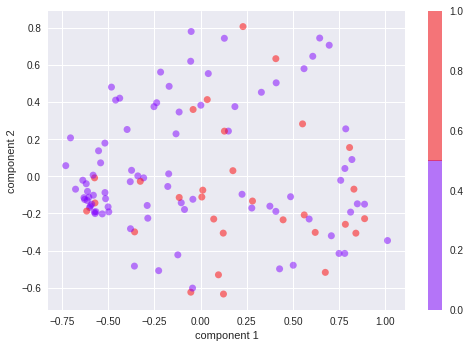

In [0]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

projected = PCA(2).fit_transform(x_test_embed)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
X_embedded.shape

In [0]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y_valid, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
0.67156960180216

In [0]:
len(y_valid)